In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Logbook 6 

## Generalising (12/03/2023)

I want to make some functions that make new variables for me so I don't have to assign so many darn variables. In this logbook I'll basically be replicating my findings from Logbook 5 using a generalised integrator.

In [4]:
def initialise_variables(N, Nbodies, Ndim):
    """
    This function resets and creates variables for position, velocity, etc., for however many bodies there are
    
    Inputs:
    N
    Nbodies
    Ndim   
    """
    
    PN = np.zeros((Nbodies, N, Ndim))
    
    VN = np.zeros((Nbodies, N, Ndim))
    
    M = np.zeros((Nbodies))
    
    return PN, VN, M

In [5]:
N = 480000
G = 1
Ndim = 3

Nbodies = 4

RN, VN, M = initialise_variables(N, Nbodies, Ndim)

# So RN[0] corresponds to the first body, RN[1] corresponds to the second and so on...

print(f"The positions of the first body are \n {RN[0]}") 

print(f"The initial position of the first body is \n {RN[0,0]}") 

print(f"The initial x position of the first body is \n {RN[0,0,0]}") 


The positions of the first body are 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
The initial position of the first body is 
 [0. 0. 0.]
The initial x position of the first body is 
 0.0


We can now impose some initial conditions:

Initial positions are 
R1 : [-0.01996008  0.          0.        ] 
R2 : [9.98003992 0.         0.        ] 
R3 : [4.98003992 8.66025404 0.        ] 
R4 : [ 4.98003992 -8.66025404  0.        ] 
Initial velocities are 
V1 : [ 0.         -0.00629933  0.        ]
V2 : [0.         3.16227766 0.        ]
V3 : [-2.74409001  1.57797655  0.        ]
V4 : [ 2.74409001  1.57797655 -0.        ]
Masses are 
M1 : 1000.0
M2 : 2.0
M3 : 1e-06
M4 : 1e-06


(-11.0, 11.0)

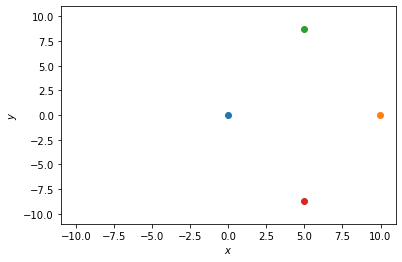

In [7]:
RN[0,0] = np.array([-0.01996008,0,0])
RN[1,0] = np.array([9.98003992,0,0])
RN[2,0] = np.array([4.98003992  ,8.66025404,0])
RN[3,0] = np.array([4.98003992  , -8.66025404  , 0])

VN[0,0] = np.array([0,-0.00629933,0])
VN[1,0] = np.array([0,3.16227766,0])
VN[2,0] = np.array([-2.74409001,1.57797655,0.])
VN[3,0] = np.array([ 2.74409001,1.57797655,-0.])

M[0] = 1000
M[1] = 2
M[2] = 1e-6
M[3] = 1e-6

print("Initial positions are ")
for i in range(Nbodies):
    print(f"R{i+1} : {RN[i,0]} ")

print("Initial velocities are ")
for i in range(Nbodies):
    print(f"V{i+1} : {VN[i,0]}")

print("Masses are ")
for i in range(Nbodies):
    print(f"M{i+1} : {M[i]}")
    
plt.figure()
    
for i in range(Nbodies):
    plt.plot(RN[i,0,0], RN[i,0,1], 'o')
    




plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

plt.xlim(-11,11)
plt.ylim(-11,11)

These are exactly the same values for Logbook 5

In [9]:
def force(G, m1, m2, r1, r2):
    """
    Returns the force acting on m1 due to m2
    inputs:
    G     gravitational constant
    m1    mass of body 1
    m2    mass of body 2
    r1    radius of body 1
    r2    radius of body 2
    outputs:
    f     the force acting on m1 due to m2  
    """
    
    f = np.array([0,0,0])
    
    r_12 = r2 - r1
    r_12_mag = np.linalg.norm(r_12) ** 3  + 1e-9 # This little factor of 1e-9 prevents any NaN errors
    
    f = G * (m1 * m2 * r_12) / r_12_mag
    return f

## An N-body Verlet (12/03/2023)

Now let's make a generalised N-body Verlet. First I want to think about how I loop over the forces. The array for the forces should be $N$ steps long, with $N_{dim}$ dimensions and $N_{bodies}$ bodies:


$$
\underbrace{\begin{pmatrix} 
F_{x_0}^{(0)} & F_{y_0}^{(0)} & F_{z_0}^{(0)} \\
 & \vdots & \\
F_{x_N}^{(0)} & F_{y_N}^{(0)} & F_{z_N}^{(0)} \\
\end{pmatrix}...
\begin{pmatrix} 
F_{x_0}^{(3)} & F_{y_0}^{(3)} & F_{z_0}^{(3)} \\
 & \vdots & \\
F_{x_N}^{(3)}& F_{y_N}^{(3)} & F_{z_N}^{(3)} \\
\end{pmatrix}}_{N_{bodies} = 3} 
$$

The total force acting on a single body is the sum of all of the forces of the other bodies, without double counting.

In [11]:
def Verlet_N_bodies(G, M, RN, VN, dt, N, Nbodies):
    """
    Generalised N-body Velocity Verlet algorithm, loops over all combinations of forces without double counting
    
    Inputs:
    G        Gravitational constant
    M        Array containing all the masses of all bodies
    RN       Array containing all the positions of all bodies
    VN       Array containing all the velocities of all bodies
    dt       timestep
    N        number of steps
    Nbodies  number of bodies
    
    Outputs:
    RN       Updated array containing all the positions of all bodies
    VN       Updated array containing all the velocities of all bodies
    """
    
    f = np.zeros((Nbodies, N, Ndim)) # force at timestep i
    F = np.zeros((Nbodies, N, Ndim)) # force at timestep i+1  

    for i in range(N - 1): # Loop over all time steps - 1

        # Loop over bodies

        for j in range(Nbodies):
            for k in range(Nbodies):
                if j != k: # avoid double counting
                    f[j, i] += force(G, M[j], M[k], RN[j,i], RN[k,i])

            RN[j, i + 1] = RN[j, i, :] + dt * VN[j, i] + (dt * dt * f[j, i]) / (2 * M[j])
            
        for j in range(Nbodies):
            for k in range(Nbodies): # This can also be for k in range(j, Nbodies) with some extra fiddling
                if j != k: # avoid double counting
                    F[j, i] += force(G, M[j], M[k], RN[j,i+1], RN[k,i+1])


            VN[j, i + 1] = VN[j, i, :] + dt * (f[j,i] + F[j,i]) / (2 * M[j])
            
    return RN, VN

In [12]:
%%time
dt = 1e-5

RN, VN = Verlet_N_bodies(G, M, RN, VN, dt, N, Nbodies)

CPU times: total: 2min 53s
Wall time: 4min 36s


(-11.0, 11.0)

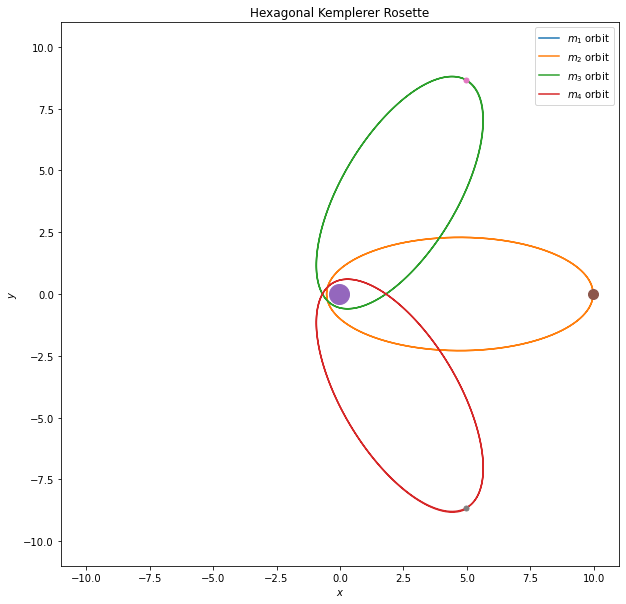

In [13]:
plt.figure(figsize = (10,10))


for i in range(Nbodies):
    plt.plot(RN[i,:,0], RN[i,:,1], label = fr"$m_{i+1}$ orbit")

plt.plot(RN[0,0,0], RN[0,0,1], 'o', markersize = 20)
plt.plot(RN[1,0,0], RN[1,0,1], 'o', markersize = 10)
plt.plot(RN[2,0,0], RN[2,0,1], 'o', markersize = 5 )
plt.plot(RN[3,0,0], RN[3,0,1], 'o', markersize = 5 )

plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

plt.legend(loc = 'upper right')
plt.title("Hexagonal Kemplerer Rosette")
plt.ylim(-11,11)
plt.xlim(-11,11)

## 2 hours later... (12/03/2023)

I initially had some trouble with figuring out the verlet algorithm for n bodies but I think it should be correct as it is. As reference (in case I change it later), it is:

```
%%time
f = np.zeros((Nbodies, N, Ndim)) # force at timestep i
F = np.zeros_like(f) # force at timestep i+1

dt = 1e-5
G = 10

for i in range(N - 1): # Loop over all time steps
    
    # Loop over bodies
    
    for j in range(Nbodies):
        for k in range(Nbodies):
            if j != k: # avoid double counting
                f[j, i] += force(G, M[j], M[k], RN[j,i], RN[k,i])
                
        RN[j, i + 1] = RN[j, i, :] + dt * VN[j, i] + (dt * dt * f[j, i]) / (2 * M[j])
                
        for k in range(Nbodies):
            if j != k: # avoid double counting
                F[j, i] += force(G, M[j], M[k], RN[j,i+1], RN[k,i+1])
            
        
        VN[j, i + 1] = VN[j, i, :] + dt * (f[j,i] + F[j,i]) / (2 * M[j])
```

Strangely, this orbit is not as stable as the one in Logbook 5, maybe I copied down the initial conditions wrong? Is my algorithm wrong? I'll have to look at this again...

Text(0.5, 0, '$z$')

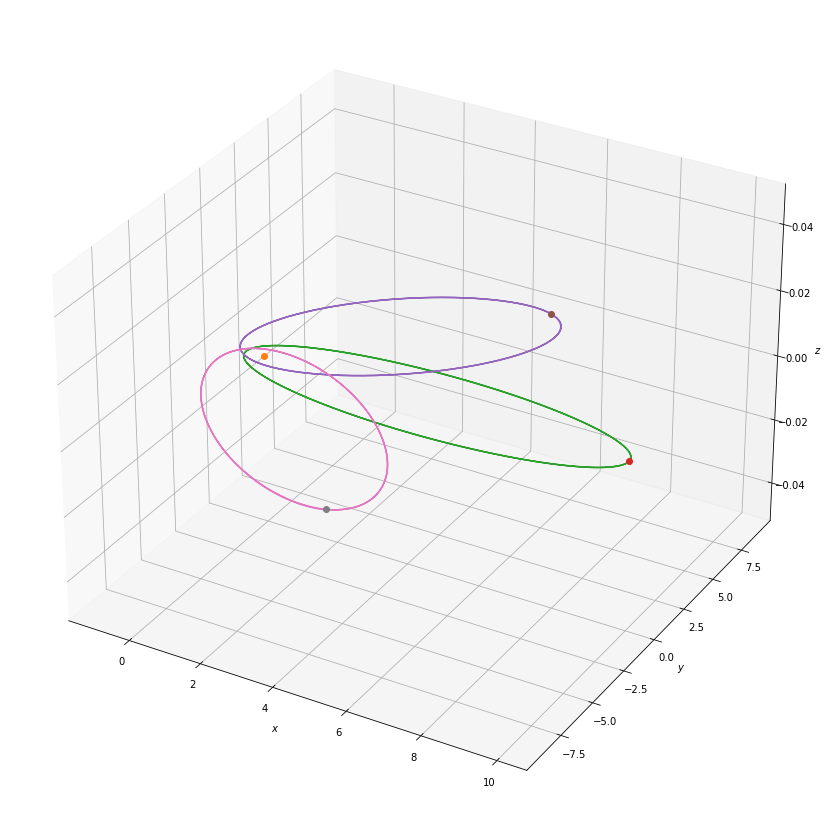

In [14]:
fig = plt.figure(figsize = (15,15))
ax = plt.axes(projection='3d')

for i in range(Nbodies):
    ax.plot3D(RN[i,:,0], RN[i, :,1], RN[i, :,2])
    plt.plot(RN[i,0,0], RN[i,0,1], RN[i,0,2], 'o', label = r"$m_1$ orbit")


ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")

## Changes (13/03/2023)

I had a chat with Prof Bowler and I've now changed my function to 

```
    
    f = np.zeros((Nbodies, N, Ndim)) # force at timestep i
    F = np.zeros((Nbodies, N, Ndim)) # force at timestep i+1  

    for i in range(N - 1): # Loop over all time steps - 1

        # Loop over bodies

        for j in range(Nbodies):
            for k in range(Nbodies):
                if j != k: # avoid double counting
                    f[j, i] += force(G, M[j], M[k], RN[j,i], RN[k,i])

            RN[j, i + 1] = RN[j, i, :] + dt * VN[j, i] + (dt * dt * f[j, i]) / (2 * M[j])
            
        for j in range(Nbodies):
            for k in range(Nbodies):
                if j != k: # avoid double counting
                    F[j, i] += force(G, M[j], M[k], RN[j,i+1], RN[k,i+1])


            VN[j, i + 1] = VN[j, i, :] + dt * (f[j,i] + F[j,i]) / (2 * M[j])
            
    return RN, VN
```

I previously left out the second `for` loop because I thought it was unnecessary, but actually if I don't use this extra loop I iterate for the forces in the next timestep without updating the position `RN[j, i+1]` for the other bodies.

## Changes part 2 (13/03/2023)

To summarise, yesterday's Logbook 5 had a bunch of tiny errors in it that somehow cancelled out to produce a completely correct orbit. The first error was in my Verlet algorithm (I'm going to have to fix this for my three body now), where I calculated the $(i+1)^{th}$ force, which uses the $(i+1)^{th}$ position, before I calculated the $(i+1)^{th}$ position. This resulted in my orbit becoming very unstable (spiraling slightly into itself).

Physically, I interpreted this as the fact that the Lagrange points L4 and L5 are inherently still unstable (although still more stable than L1 and L2), and in fact move around slightly. However, after setting $G=1$, I've found that the orbit returned back to being stable, and now I'm not too sure what to make of my physical interpretation.

Now, I think I will try to plot 6 bodies of alternating masses moving around the central star. I could also perhaps do 4 and 8 bodies too, but they lack inherent stability. The positions of these bodies should be on the vertices of a regular polygon.

This will probably be updated at some point, but for now, this is the end of Logbook 6.